## OBJECTIF
--------------------------------

QUICKLOOKS PREDICTED BY 
- NON-LINEAR FUNCTIONS 
- DECISION TREE

CLASSIFICATION MASKS & STATS

QUANTIFY THESE QUICKLOOKS

## QUICKLOOKS 

In [67]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path 
import matplotlib.pyplot as plt


In [68]:
import os
os.chdir('/homedata/nmpnguyen/ORACLES-ER2/Codes')
from outils import convert_gpstime
os.getcwd()

'/mnt/homedafs-2.10/nmpnguyen/ORACLES-ER2/Codes'

In [69]:
DATES = ['20160826', '20160920', '20160924', '20160916']

In [78]:
MAINDIR = Path('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/')
DATE = '20160819'
PARTTERN = f'HSRL2_ER2_{DATE}*_v2.nc'
FILE = sorted(MAINDIR.glob(PARTTERN))[0]
print(FILE)
DATA = xr.open_dataset(FILE)
SR355 = (DATA['calibrated']/DATA['molecular']).sel(wavelength = 355).dropna('time', 'all')
SR532 = (DATA['calibrated']/DATA['molecular']).sel(wavelength = 532).dropna('time', 'all')
TIME = np.intersect1d(np.intersect1d(SR355.time, DATA.time), np.intersect1d(SR532.time, DATA.time))#DATA['time'].values
ALTITUDE = DATA['altitude'].values/1000 #(km)

SR355 = SR355.sel(time = TIME)
SR532 = SR532.sel(time = TIME)

/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/HSRL2_ER2_20160819_R8_v2.nc


In [71]:
# TIME=convert_gpstime(TIME, DATE, True).values

# (TIME.dtype), pd.to_datetime(TIME).dtype, TIME

In [79]:
MAINDIR = Path('/homedata/nmpnguyen/ORACLES-ER2/')
PARTTERN = f'HSRL2_ER2_{DATE}_R8.h5'
FILE = sorted(MAINDIR.glob(PARTTERN))[0]
print(FILE)
DATA = xr.open_dataset(FILE, group = 'Nav_Data')
IND_TIME = np.intersect1d(DATA.gps_time, TIME, return_indices=True)[1]
DATA = xr.open_dataset(FILE, group = 'DataProducts')
BETAPART355 = DATA['355_bsc'].isel(phony_dim_0 = IND_TIME)#.dropna('phony_dim_0', 'all')
print(BETAPART355)

/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160819_R8.h5
<xarray.DataArray '355_bsc' (phony_dim_0: 810, phony_dim_1: 1389)>
[1125090 values with dtype=float64]
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    Description:                      355 nm aerosol backscatter coefficient
    chi:                              0.9923
    Unit:                             km^-1sr^-1
    run_date:                         23-Jun-2017 10:10:30
    Horizontal resolution (seconds):  10.0
    Vertical resolution (meters):     15.0
    molecular depolarization:         0.0037
    code_date:                        26-Apr-2017
    StandardName:                     AerOpt_BackScattering_Profile_UV_RHa_Bu...
    Description2:                     None


In [82]:
DATA['355_AOT_hi_col']

<xarray.DataArray '355_AOT_hi_col' (phony_dim_0: 1404, phony_dim_1: 1389)>
[1950156 values with dtype=float64]
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes: (12/13)
    Unit:                                                               none
    Horizontal resolution (seconds):                                    60.0
    near field altitude offset (m):                                     1500.0
    Low signal mask applied (1 means yes):                              1
    Description:                                                        355 n...
    cloud screen:                                                       active
    ...                                                                 ...
    Masked for cirrus clouds at altitude greater than or equal to (m):  10000.0
    code_date:                                                          19-Ju...
    cloud backoff:                                                      0.0
    run_date:                                                           19-Ju...
    StandardName:                                                       AerOp...
    Description2:                                                       None

In [73]:
# PREDICTION BY NON-LINEAR FUNCTION 
#-------------------------------------------------------------

# f = lambda x : 0.20704*np.log(x) + 4.8181
f = lambda x : 4.6758 + (-3.6411/(1 + (x/0.0038)**1.0107))
RATIO_PRED = f(BETAPART355)
SR532_PRED = RATIO_PRED.values * SR355.values
print('shape of SR532 raw & predictive :', SR532_PRED.shape, SR532.shape)

shape of SR532 raw & predictive : (810, 1389) (810, 1389)


In [74]:
# PREDICTION BY DECISION TREE
#-------------------------------------------------------------

MAINDIR = Path('/homedata/nmpnguyen/ORACLES-ER2/leaning_model_test/Products/')
PATTERN = f'tree_3f.sav-HSRL2-ER2-{DATE}_vNA*.nc'

FILE = sorted(MAINDIR.glob(PATTERN))[0]
print(FILE)
DATA = xr.open_dataset(FILE)
DATA

SR532_PRED_TREE = DATA['SR532_predicted']
SR532_TREE = DATA['SR532_measured']
TIME_TREE = pd.to_datetime(DATA['time'].values)



/homedata/nmpnguyen/ORACLES-ER2/leaning_model_test/Products/tree_3f.sav-HSRL2-ER2-20160819_vNA0.nc


In [75]:
TIME = convert_gpstime(TIME, DATE, True).values

In [76]:
def find_nearest(time_array, value):
    time_array, value = pd.to_datetime(time_array), pd.to_datetime(value)
    idt = (np.abs(time_array - value)).argmin()
    value = time_array[idt]
    return idt, value

T_INDEX, TT_INDEX = find_nearest(TIME, '2016-08-19 18:00')[0], find_nearest(TIME_TREE, '2016-08-19 18:00')[0]

<Figure size 432x288 with 0 Axes>

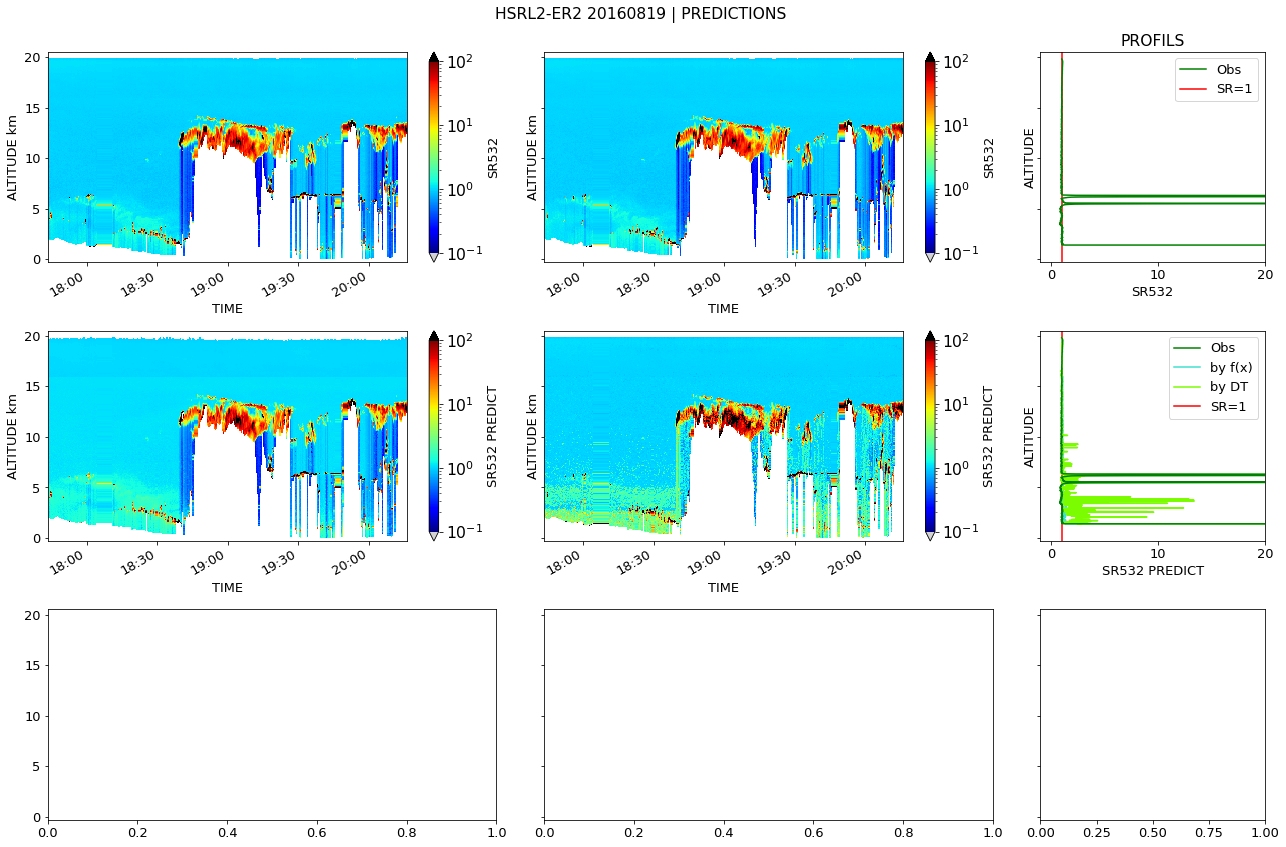

In [77]:
from matplotlib.colors import LogNorm 
import matplotlib.dates as mdates
import matplotlib as mpl
import warnings 
warnings.filterwarnings("ignore")

plt.clf()

FIG, ((ax), (ax2), (ax3)) = plt.subplots(ncols = 3, nrows = 3, 
                                         figsize = (18,12), sharey=True, 
                                         gridspec_kw={'width_ratios': [2,2,1]})
cmapp = mpl.cm.get_cmap("jet")
cmapp.set_over('black')
cmapp.set_under('lightgrey')
plt.rcParams['font.size'] = 13
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'



#--------------------------------------------------
# BY FUNCTION 
#--------------------------------------------------

p = ax[0].pcolormesh(TIME, ALTITUDE, SR532.T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=100))
plt.colorbar(p, ax=ax[0], label = 'SR532', extend='both')
ax[0].set_xlabel('TIME')
ax[0].set_ylabel('ALTITUDE km')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax[0].set_title('by fitting linear')

p2 = ax2[0].pcolormesh(TIME, ALTITUDE, SR532_PRED.T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=100))
plt.colorbar(p2, ax=ax2[0], label = 'SR532 PREDICT', extend='both')
ax2[0].set_xlabel('TIME')
ax2[0].set_ylabel('ALTITUDE km')
ax2[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# p3 = ax3[0].pcolormesh(TIME, ALTITUDE, np.abs(SR532_PRED - SR532).T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=10))
# plt.colorbar(p3, ax=ax3[0], label = '| SR532 PREDICT - SR532 |', extend='both')
# ax3[0].set_xlabel('TIME')
# ax3[0].set_ylabel('ALTITUDE km')

#--------------------------------------------------
# BY DECISION TREE 
#--------------------------------------------------
pp = ax[1].pcolormesh(TIME_TREE, ALTITUDE, SR532_TREE.T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=100))
plt.colorbar(pp, ax=ax[1], label = 'SR532', extend='both')
ax[1].set_xlabel('TIME')
ax[1].set_ylabel('ALTITUDE km')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax[1].set_title('by Decision Tree (DT), dropna=True')

pp2 = ax2[1].pcolormesh(TIME_TREE, ALTITUDE, SR532_PRED_TREE.T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=100))
plt.colorbar(pp2, ax=ax2[1], label = 'SR532 PREDICT', extend='both')
ax2[1].set_xlabel('TIME')
ax2[1].set_ylabel('ALTITUDE km')
ax2[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# pp3 = ax3[1].pcolormesh(TIME_TREE, ALTITUDE, np.abs(SR532_PRED_TREE - SR532_TREE).T, cmap = cmapp, norm=LogNorm(vmin=1e-1, vmax=10))
# plt.colorbar(pp3, ax=ax3[1], label = '| SR532 PREDICT - SR532 |', extend='both')
# ax3[1].set_xlabel('TIME')
# ax3[1].set_ylabel('ALTITUDE km')

plt.setp(ax[0].get_xticklabels() + ax[1].get_xticklabels() +
         ax2[0].get_xticklabels() + ax2[1].get_xticklabels(), #+
#          ax3[0].get_xticklabels() + ax3[1].get_xticklabels(), 
         rotation=30, ha='right')

#--------------------------------------------------
# PROFILS
# setting 1 profil's index
#--------------------------------------------------

ax[2].plot(SR532[T_INDEX, :], ALTITUDE, color='green', label='Obs', zorder=10)
ax[2].axvline(1, color='red', label='SR=1', zorder=0)
ax[2].set_xlabel('SR532')
ax[2].set_title('PROFILS')
ax[2].set_ylabel('ALTITUDE')
ax[2].legend(loc='best')
ax[2].set_xlim(-1,20)

ax2[2].plot(SR532[T_INDEX, :], ALTITUDE, color='green', label='Obs', zorder=10)
ax2[2].plot(SR532_PRED[T_INDEX, :], ALTITUDE, color='turquoise', label='by f(x)')
ax2[2].plot(SR532_PRED_TREE[TT_INDEX, :], ALTITUDE, color='lawngreen', label='by DT')
ax2[2].axvline(1, color='red', label='SR=1', zorder=0)
ax2[2].set_xlabel('SR532 PREDICT')
ax2[2].set_ylabel('ALTITUDE')
ax2[2].legend(loc='best')
ax2[2].set_xlim(-1,20)

# ax3[2].plot(np.abs(SR532_PRED[T_INDEX, :] - SR532[T_INDEX, :]), ALTITUDE, color='turquoise', label='by f(x)')
# ax3[2].plot(np.abs(SR532_PRED_TREE[TT_INDEX, :] - SR532_TREE[TT_INDEX, :]), ALTITUDE, color='lawngreen', label='by DT')
# ax3[2].axvline(0, color='red', label='SR=0', zorder=0)
# ax3[2].set_xlabel('RESIDUS |SR532 PREDICT - SR532|')
# ax3[2].set_ylabel('ALTITUDE')
# ax3[2].legend(loc='best')
# ax3[2].set_xlim(-1,20)

plt.suptitle(f'HSRL2-ER2 {DATE} | PREDICTIONS')
plt.tight_layout()

(-1.0, 16.0)

<Figure size 432x288 with 0 Axes>

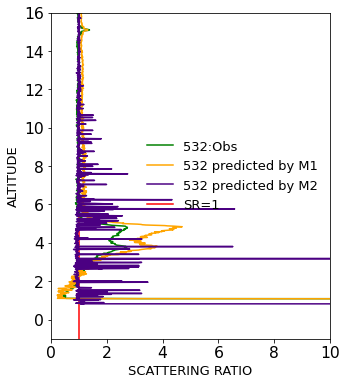

In [138]:
T_INDEX = find_nearest(TIME, '2016-09-24 11:45')[0]

plt.clf()
fig, ax2 = plt.subplots(figsize=(5, 6))
plt.rcParams['font.size'] = 13
# plt.rcParams['xtick.labelsize'] = 'large'
# plt.rcParams['ytick.labelsize'] = 'large'
# ax2.plot(SR355[T_INDEX, :], ALTITUDE, color='blue', label='355:Obs', zorder=9)
ax2.plot(SR532[T_INDEX, :], ALTITUDE, color='green', label='532:Obs')
ax2.plot(SR532_PRED[T_INDEX, :], ALTITUDE, color='orange', label='532 predicted by M1')
ax2.plot(SR532_PRED_TREE[TT_INDEX, :], ALTITUDE, color='indigo', label='532 predicted by M2')
ax2.axvline(1, color='red', label='SR=1', zorder=0)
ax2.set_xlabel('SCATTERING RATIO')
ax2.set_ylabel('ALTITUDE')
ax2.legend(loc='center right', frameon=False, facecolor='white', framealpha=1)
ax2.set_xlim(-0,10)
ax2.set_ylim(-1,16)

### CLASSIFICATION MASKS & STATS
------------------------------------

    FA : SR < 0.06
    S : SR = [0.06, 1.2]
    U : SR = (1.2, 5) 
    C : SR >= 5

In [14]:
def get_mask_SR_at_alt(input_data, alt):
    '''
    Input:
        - input_data: data array 1D or 2D is required
        - alt : altitude array at the same shape of input_data
    
    Output:
        - data array grouped following Flags (rows) and Altitude (colonnes)
        'A' = 'Fully Attenuated'
        'C' = 'Cloud'
        'S' = 'Clear Sky'
        'U' = 'Uncertain'
        
    '''
    ### SET LABELS CLASSIFICATIONS OF SR
    labels = np.full(input_data.shape, 'A')
    labels[(input_data < 0.06) | (np.isnan(input_data))] = 'A'
    labels[input_data > 5.0] = 'C'
    labels[np.logical_and(input_data >= 0.06, input_data <= 1.2)] = 'S'
    labels[np.logical_and(input_data > 1.2, input_data < 5.0)] = 'U'
    
    ### CREATE DATAFRAME WHAT DEFINE THE ALTITUDE EDGES BEFORE GROUPBY 
    if len(input_data.shape) == 2:
        labels_df = pd.DataFrame(np.concatenate([input_data.ravel().reshape(-1,1), 
                                                 alt.ravel().reshape(-1,1)], axis=1),
                                 columns=['SR532', 'ALTITUDE'])
    else: 
        labels_df = pd.DataFrame(np.concatenate([input_data.reshape(-1,1), 
                                                 alt.reshape(-1,1)], axis=1),
                                 columns=['SR532', 'ALTITUDE'])
    
    labels_df['ALTITUDE_EDGES'] = pd.cut(labels_df['ALTITUDE'], bins=80)
    labels_df['FLAGS'] = labels.reshape(-1,1)
    
    ### GROUP DATA BY FLAGS & ALTITUDE
    labels_df_grouped = labels_df.groupby(['FLAGS','ALTITUDE_EDGES']).size().unstack()
    labels_df_grouped.columns = np.linspace(alt.min(), alt.max(), 80)
    alt_return = labels_df_grouped.columns.values
    
    ### CREATE TOTAL HORIZONTAL POINTS ARRAY FROM GROUPING ALTITUDE EDGES 
    total_horizontal_pts = labels_df.groupby('ALTITUDE_EDGES').size().values.T
    
    ### CALCULATE FRACTION
    labels_df_fraction = labels_df_grouped.values/total_horizontal_pts
    return labels_df_fraction, alt_return


In [131]:
ALTITUDE_2D = np.tile(ALTITUDE, (SR532.shape[0], 1))
LABELS_GROUPED, ALT = get_mask_SR_at_alt(SR532.values, ALTITUDE_2D)

ALTITUDE_2D = np.tile(ALTITUDE, (SR532_PRED.shape[0], 1))
LABELS_GROUPED_PRED, ALT_1 = get_mask_SR_at_alt(SR532_PRED, ALTITUDE_2D)

ALTITUDE_2D = np.tile(ALTITUDE, (SR532_PRED_TREE.shape[0], 1))
LABELS_GROUPED_TREE, ALT_2 = get_mask_SR_at_alt(SR532_PRED_TREE.values, ALTITUDE_2D)

In [132]:
len(LABELS_GROUPED)

4

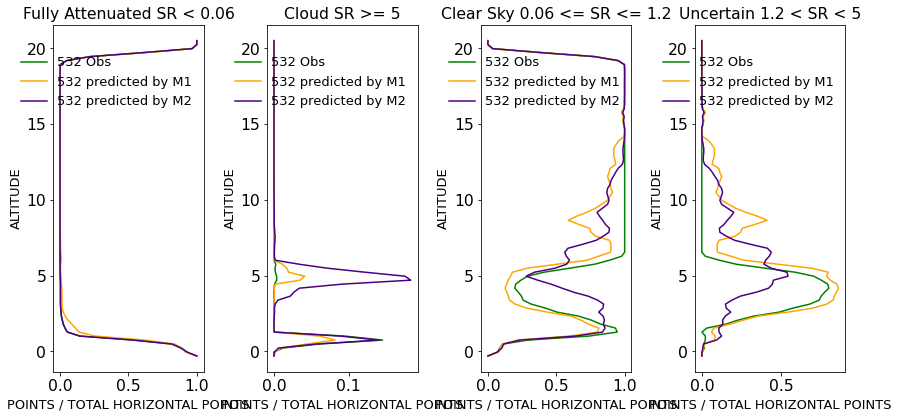

In [133]:
LABELS_STRING = ['Fully Attenuated SR < 0.06','Cloud SR >= 5', 'Clear Sky 0.06 <= SR <= 1.2', 'Uncertain 1.2 < SR < 5'] #'Fully Attenuation', 
FIG, AXS = plt.subplots(figsize=(12,6), ncols=4)
for (i, AX) in enumerate(AXS.flat):
    AX.plot(LABELS_GROUPED[i,:], ALT, color='green', label='532 Obs')
    AX.plot(LABELS_GROUPED_PRED[i,:], ALT_1, color='orange', label='532 predicted by M1')
    AX.plot(LABELS_GROUPED_TREE[i,:], ALT_2, color='indigo', label='532 predicted by M2')
    AX.legend(title=' ', frameon=False, loc='best')
    AX.set_title(LABELS_STRING[i])
    AX.set_xlabel('POINTS / TOTAL HORIZONTAL POINTS')
    AX.set_ylabel('ALTITUDE')
#     ax.set_xlim([-0.05, 1.0])
# plt.legend(frameon=False, title='FLAGS', bbox_to_anchor=(1, 0.95))
# plt.xlabel('NOMBRE DES POINTS')
# plt.ylabel('ALTITUDE')
# plt.grid()

plt.tight_layout()

In [23]:
### GET ALL DATASET FOR CLASSIFICATION
#--------------------------------------

MAINDIR = Path('/homedata/nmpnguyen/ORACLES-ER2/leaning_model_test/Products/')

SR532 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_ravel.pkl')).values
SR532_PRED = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_LOG_FUNCTION.pkl')).values
SR532_PRED2 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_LINEAR_FUNCTION.pkl')).values

SR532_PRED_TREE2 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_NA_ravel_by_DECISION_TREE.pkl')).values
SR532_PRED_TREE = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_DECISION_TREE.pkl')).values

ALTITUDE_2D = pd.read_pickle(Path(MAINDIR, 'TOTAL_ALTITUDE_2D_ravel.pkl')).values
ALTITUDE_2D_TREE = pd.read_pickle(Path(MAINDIR, 'TOTAL_ALTITUDE_2D_TREE_ravel_by_DECISION_TREE.pkl')).values


In [24]:
# LABELS_GROUPED, ALT = get_mask_SR_at_alt(SR532, ALTITUDE_2D)

# LABELS_GROUPED_PRED, ALT_1 = get_mask_SR_at_alt(SR532_PRED, ALTITUDE_2D)
# LABELS_GROUPED_PRED2, ALT_1 = get_mask_SR_at_alt(SR532_PRED2, ALTITUDE_2D)

# LABELS_GROUPED_TREE, ALT_2 = get_mask_SR_at_alt(SR532_PRED_TREE, ALTITUDE_2D_TREE)
LABELS_GROUPED_TREE2, ALT_2 = get_mask_SR_at_alt(SR532_PRED_TREE2, ALTITUDE_2D_TREE)

<ipython-input-33-6b4dff68de78>:30: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


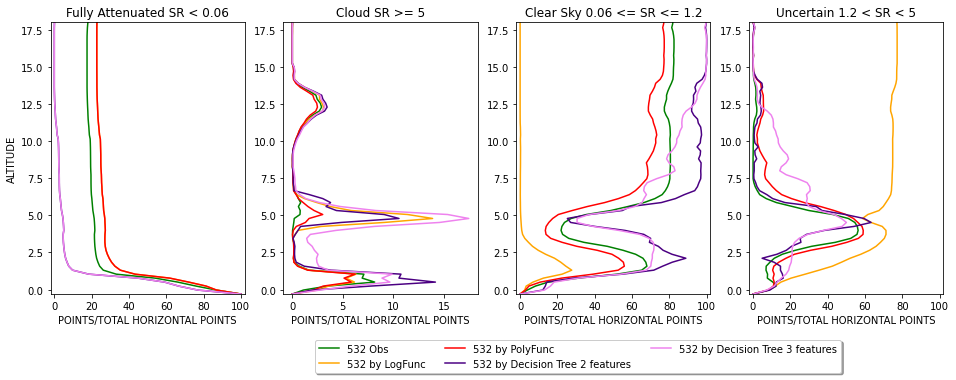

In [33]:
LABELS_STRING = ['Fully Attenuated SR < 0.06', 'Cloud SR >= 5', 'Clear Sky 0.06 <= SR <= 1.2', 'Uncertain 1.2 < SR < 5'] #'Fully Attenuation', 
LEGENDS_STRING = {'green' : '532 Obs',
                 'orange' : '532 by LogFunc',
                 'red' : '532 by PolyFunc',
                 'violet' : '532 by Decision Tree 2 features',
                 'indigo' : '532 by Decision Tree 3 features'}
FIG, AXS = plt.subplots(figsize=(16,5), ncols=4)
for (i, AX) in enumerate(AXS.flat):
    AX.plot(LABELS_GROUPED[i, :]*100, ALT, color='green', label=LEGENDS_STRING['green'])
    AX.plot(LABELS_GROUPED_PRED[i, :]*100, ALT_1, color='orange', label=LEGENDS_STRING['orange'])
    AX.plot(LABELS_GROUPED_PRED2[i, :]*100, ALT_1, color='red', label=LEGENDS_STRING['red'])

    AX.plot(LABELS_GROUPED_TREE[i, :]*100, ALT_2, color='indigo', label=LEGENDS_STRING['violet'])
    AX.plot(LABELS_GROUPED_TREE2[i, :]*100, ALT_2, color='violet', label=LEGENDS_STRING['indigo'])

#     AX.legend(title=' ', frameon=False, loc='best')
    if (i == 3):
        AX.legend(bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
    AX.set_title(LABELS_STRING[i])
    AX.set_xlabel('POINTS/TOTAL HORIZONTAL POINTS')
    if (i == 0):
        AX.set_ylabel('ALTITUDE')
    if (i != 1):
        AX.set_xlim([-2, 102])
    AX.set_ylim([ALT.min(),18])
#     AX.legend(frameon=False)



plt.tight_layout()

## QUANTIFY PREDICTION VS OBS.

- around the diagonal
- prediction band 95%

In [50]:
import os
os.getcwd()

'/mnt/homedafs-2.10/nmpnguyen/comparaison/Codes'

In [35]:
os.chdir('/homedata/nmpnguyen/comparaison/Codes')
from fonctions import dataset, conditions, get_file, check, conversion, plots
os.getcwd()

'/mnt/homedafs-2.10/nmpnguyen/comparaison/Codes'

In [37]:
# IMPOTER LES DONNÉES PRÉDICTES DE PLUSIEURS JOURS 
MAINDIR = Path('/homedata/nmpnguyen/ORACLES-ER2/leaning_model_test/Products/')
SR355 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR355_ravel.pkl')).values.ravel()
SR532 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_ravel.pkl')).values.ravel()
SR532_PRED = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_LOG_FUNCTION.pkl')).values.ravel()
SR532_PRED2 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_LINEAR_FUNCTION.pkl')).values.ravel()

SR355_TREE = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR355_TREE_ravel.pkl')).values.ravel()
SR532_TREE = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_TREE_ravel.pkl')).values.ravel()
SR532_PRED_TREE = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_ravel_by_DECISION_TREE.pkl')).values.ravel()
SR532_PRED_TREE2 = pd.read_pickle(Path(MAINDIR, 'TOTAL_SR532_PRED_NA_ravel_by_DECISION_TREE.pkl')).values.ravel()
# TIME = pd.read_pickle(Path(MAINDIR, 'TIME.pkl'))
# TIME_TREE = pd.read_pickle(Path(MAINDIR, 'TIME_TREE.pkl'))

MIN_MAX_VALUE = [0.0,80.0]
# PTS_STATSo = pd.read_pickle(Path(MAINDIR, f'LogFunction-HSRL2-ER2-DataTest_Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))
# PTS_STATS_TREEo = pd.read_pickle(Path(MAINDIR, f'tree_3f-HSRL2-ER2-DataTest_Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))

In [84]:
SR532.shape[0]/SR532_TREE.shape[0]

1.2944845129221008

In [39]:
print('----------------QUANTIFY--------------------')

UNIT_VALUE = np.arange(0.05, 2, 0.2)
MIN_MAX_VALUE = [0.0,80.0]
PTS_STATS = []
PTS_STATS_TREE = []
DF_PTS = []
DF_PTS_TREE = []

for u in UNIT_VALUE:
    PTS = check(min_value_x=MIN_MAX_VALUE[0], min_value_y=MIN_MAX_VALUE[0], max_value_x=MIN_MAX_VALUE[1], max_value_y=MIN_MAX_VALUE[1], 
                closed_unit = u, x_data=SR532, y_data=SR532_PRED)
    PTS_STATS.append(PTS.quantify())
    print(f'Quantify predicted data within +/- {u} unit around the diagonal and between {MIN_MAX_VALUE}: {PTS.quantify()} %')
    DF_PTS.append(SR532[np.where(PTS.check_point())[0]].reshape(-1,1))
    PTS = check(min_value_x=MIN_MAX_VALUE[0], min_value_y=MIN_MAX_VALUE[0], max_value_x=MIN_MAX_VALUE[1], max_value_y=MIN_MAX_VALUE[1], 
                closed_unit = u, x_data=SR532_TREE, y_data=SR532_PRED_TREE)
    PTS_STATS_TREE.append(PTS.quantify())
    print(f'Quantify predicted data within +/- {u} unit around the diagonal and between {MIN_MAX_VALUE}: {PTS.quantify()} %')
    DF_PTS_TREE.append(SR532_TREE[np.where(PTS.check_point())[0]].reshape(-1,1))

----------------QUANTIFY--------------------
Quantify predicted data within +/- 0.05 unit around the diagonal and between [0.0, 80.0]: 0.3906542209421305 %
Quantify predicted data within +/- 0.05 unit around the diagonal and between [0.0, 80.0]: 52.297167026962576 %
Quantify predicted data within +/- 0.25 unit around the diagonal and between [0.0, 80.0]: 1.8160317114869746 %
Quantify predicted data within +/- 0.25 unit around the diagonal and between [0.0, 80.0]: 72.32345354952074 %
Quantify predicted data within +/- 0.45 unit around the diagonal and between [0.0, 80.0]: 3.0692836007440683 %
Quantify predicted data within +/- 0.45 unit around the diagonal and between [0.0, 80.0]: 76.72350429251986 %
Quantify predicted data within +/- 0.6500000000000001 unit around the diagonal and between [0.0, 80.0]: 4.340750535330905 %
Quantify predicted data within +/- 0.6500000000000001 unit around the diagonal and between [0.0, 80.0]: 79.89198426859483 %
Quantify predicted data within +/- 0.850000

In [38]:
print('----------------QUANTIFY--------------------')

UNIT_VALUE = np.arange(0.05, 2, 0.2)
MIN_MAX_VALUE = [0.0,80.0]
PTS_STATS2 = []
PTS_STATS_TREE2 = []
DF_PTS2 = []
DF_PTS_TREE2 = []

for u in UNIT_VALUE:
    PTS = check(min_value_x=MIN_MAX_VALUE[0], min_value_y=MIN_MAX_VALUE[0], max_value_x=MIN_MAX_VALUE[1], max_value_y=MIN_MAX_VALUE[1], 
                closed_unit = u, x_data=SR532, y_data=SR532_PRED2)
    PTS_STATS2.append(PTS.quantify())
    print(f'Quantify predicted data within +/- {u} unit around the diagonal and between {MIN_MAX_VALUE}: {PTS.quantify()} %')
    DF_PTS2.append(SR532[np.where(PTS.check_point())[0]].reshape(-1,1))
    PTS = check(min_value_x=MIN_MAX_VALUE[0], min_value_y=MIN_MAX_VALUE[0], max_value_x=MIN_MAX_VALUE[1], max_value_y=MIN_MAX_VALUE[1], 
                closed_unit = u, x_data=SR532_TREE, y_data=SR532_PRED_TREE2)
    PTS_STATS_TREE2.append(PTS.quantify())
    print(f'Quantify predicted data within +/- {u} unit around the diagonal and between {MIN_MAX_VALUE}: {PTS.quantify()} %')
    DF_PTS_TREE2.append(SR532_TREE[np.where(PTS.check_point())[0]].reshape(-1,1))

----------------QUANTIFY--------------------
Quantify predicted data within +/- 0.05 unit around the diagonal and between [0.0, 80.0]: 14.407470840955964 %
Quantify predicted data within +/- 0.05 unit around the diagonal and between [0.0, 80.0]: 47.7050062646812 %
Quantify predicted data within +/- 0.25 unit around the diagonal and between [0.0, 80.0]: 58.55931107112325 %
Quantify predicted data within +/- 0.25 unit around the diagonal and between [0.0, 80.0]: 67.2867448612519 %
Quantify predicted data within +/- 0.45 unit around the diagonal and between [0.0, 80.0]: 62.327419628362534 %
Quantify predicted data within +/- 0.45 unit around the diagonal and between [0.0, 80.0]: 71.6578124076491 %
Quantify predicted data within +/- 0.6500000000000001 unit around the diagonal and between [0.0, 80.0]: 64.05794586005285 %
Quantify predicted data within +/- 0.6500000000000001 unit around the diagonal and between [0.0, 80.0]: 75.77330533775215 %
Quantify predicted data within +/- 0.85000000000

In [66]:
# PTS_STATS, pd.read_pickle(Path(MAINDIR, f'LogFunction-HSRL2-ER2-DataTest_Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))

pd.DataFrame(PTS_STATS, index=UNIT_VALUE).to_pickle(Path(MAINDIR, f'LogFunction-HSRL2-ER2-Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))
pd.DataFrame(PTS_STATS2, index=UNIT_VALUE).to_pickle(Path(MAINDIR, f'LinearFunction-HSRL2-ER2-Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))
pd.DataFrame(PTS_STATS_TREE, index=UNIT_VALUE).to_pickle(Path(MAINDIR, f'tree_3f-HSRL2-ER2-Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))
pd.DataFrame(PTS_STATS_TREE2, index=UNIT_VALUE).to_pickle(Path(MAINDIR, f'tree_2f-HSRL2-ER2-Stats_between_{MIN_MAX_VALUE[0]}_{MIN_MAX_VALUE[1]}.pkl'))

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(SR532[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))], SR532_PRED2[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))])
MSE = mean_squared_error(SR532[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))], SR532_PRED2[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))])
R2 = np.corrcoef(SR532[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))], SR532_PRED2[np.logical_and(np.isfinite(SR532), np.isfinite(SR532_PRED2))])
print(MAE, MSE, R2[0, 1])

MAE_TREE = mean_absolute_error(SR532_TREE[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))], SR532_PRED_TREE2[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))])
MSE_TREE = mean_squared_error(SR532_TREE[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))], SR532_PRED_TREE2[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))])
R2_TREE = np.corrcoef(SR532_TREE[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))], SR532_PRED_TREE2[np.logical_and(np.isfinite(SR532_TREE), np.isfinite(SR532_PRED_TREE2))])
print(MAE_TREE, MSE_TREE, R2_TREE[0, 1])

0.37051897489011865 18.088859519234713 0.970278298157252
0.6251921888272229 23.982753538233933 0.9463404400784122


<ipython-input-49-d92f50415f42>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmapp.set_over('black')
<ipython-input-49-d92f50415f42>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmapp.set_under('lightgrey')


<Figure size 432x288 with 0 Axes>

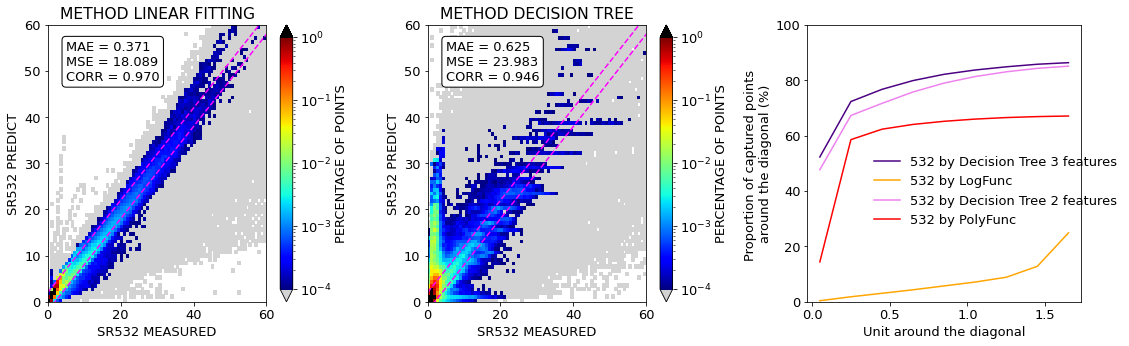

In [49]:
import matplotlib as mpl
from matplotlib.colors import LogNorm

plt.clf()
FIG, (AX, AX2, AX3) = plt.subplots(ncols =3, figsize=(16,5))
cmapp = mpl.cm.get_cmap("jet")
cmapp.set_over('black')
cmapp.set_under('lightgrey')
plt.rcParams['font.size'] = 13
# plt.rcParams['xtick.labelsize'] = 'large'
RANGES = [[0, 80], [0, 80]]
BINS = 100
#--------------------------------------------------
# BY FUNCTION
#--------------------------------------------------
COUNTS, XBINS, YBINS = np.histogram2d(SR532, SR532_PRED2, range = RANGES, bins = BINS)
COUNTS_PROPA = 100*COUNTS/SR532[~np.isnan(SR532)].shape[0]
PP = AX.pcolormesh(XBINS, YBINS, COUNTS_PROPA.T, cmap = cmapp, norm=LogNorm(vmin=1e-4, vmax=1e0))
CC = plt.colorbar(PP, ax=AX, label = 'PERCENTAGE OF POINTS', extend='both')
AX.set_xlabel('SR532 MEASURED')
AX.set_ylabel('SR532 PREDICT')
AX.set_title('METHOD LINEAR FITTING')
AX.plot(np.arange(0,80,1), np.arange(0+2,80+2,1), linestyle='--', c='magenta')
AX.plot(np.arange(0,80,1), np.arange(0-2,80-2,1), linestyle='--', c='magenta')
AX.set_ylim(0,60)
AX.set_xlim(0,60)
AX.annotate(f'MAE = {MAE:.3f}\nMSE = {MSE:.3f}\nCORR = {R2[0,1]:.3f}', xy=(5, 48), xytext=(5, 48), bbox=dict(boxstyle="round", fc="w"))
#--------------------------------------------------
# BY DECISION TREE 
#--------------------------------------------------
COUNTS, XBINS, YBINS = np.histogram2d(SR532_TREE, SR532_PRED_TREE2, range = RANGES, bins = BINS)
COUNTS_PROPA = 100*COUNTS/SR532_TREE[~np.isnan(SR532_TREE)].shape[0]
PP2 = AX2.pcolormesh(XBINS, YBINS, COUNTS_PROPA.T, cmap = cmapp, norm=LogNorm(vmin=1e-4, vmax=1e0))
CC2 = plt.colorbar(PP2, ax=AX2, label = 'PERCENTAGE OF POINTS', extend='both')
AX2.set_xlabel('SR532 MEASURED')
AX2.set_ylabel('SR532 PREDICT')
AX2.set_title('METHOD DECISION TREE')
AX2.plot(np.arange(0,80,1), np.arange(0+2,80+2,1), linestyle='--', c='magenta')
AX2.plot(np.arange(0,80,1), np.arange(0-2,80-2,1), linestyle='--', c='magenta')
AX2.set_ylim(0,60)
AX2.set_xlim(0,60)
AX2.annotate(f'MAE = {MAE_TREE:.3f}\nMSE = {MSE_TREE:.3f}\nCORR = {R2_TREE[0,1]:.3f}', xy=(5, 48), xytext=(5, 48), bbox=dict(boxstyle="round", fc="w"))
#--------------------------------------------------
# QUANTIFY LINE 
#--------------------------------------------------
AX3.plot(UNIT_VALUE[:9], PTS_STATS_TREE[:9], color='indigo', label=LEGENDS_STRING['indigo'])
AX3.plot(UNIT_VALUE[:9], PTS_STATS[:9], color='orange', label=LEGENDS_STRING['orange'])
AX3.plot(UNIT_VALUE[:9], PTS_STATS_TREE2[:9], color='violet', label=LEGENDS_STRING['violet'])
AX3.plot(UNIT_VALUE[:9], PTS_STATS2[:9], color='red', label=LEGENDS_STRING['red'])
# PTS_STATS_TREE.plot(ax=AX3, color='indigo')
# PTS_STATS[:-1].plot(ax=AX3, color='orange')
AX3.legend(loc='center left', bbox_to_anchor=(0.2, 0.4), frameon=False)
AX3.set_ylabel('Proportion of captured points \naround the diagonal (%)')
AX3.set_xlabel('Unit around the diagonal')
AX3.set_ylim(0,100)

# plt.suptitle(f'HSRL2-ER2 | QUANTIFY PREDICTED DATA')
plt.tight_layout()

<ipython-input-228-721fd5104cb2>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmapp.set_over('darkgrey')
<ipython-input-228-721fd5104cb2>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmapp.set_under('lightgrey')


<Figure size 432x288 with 0 Axes>

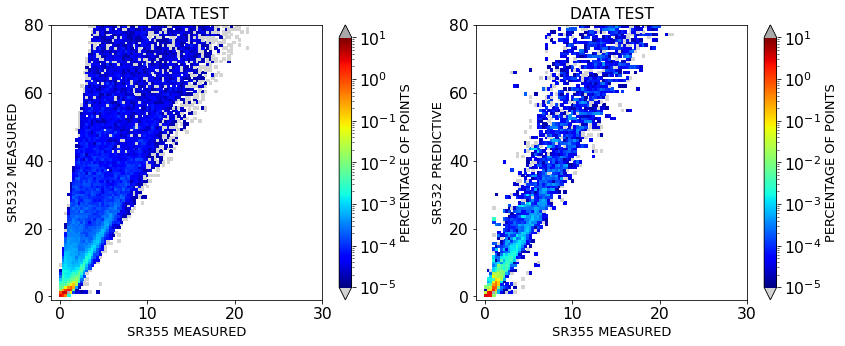

In [228]:
-

Text(0.5, 1.0, 'Prediction by DECISION TREE')

<Figure size 432x288 with 0 Axes>

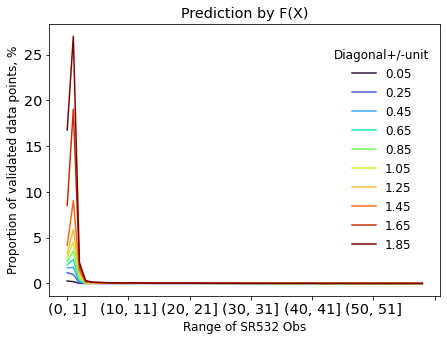

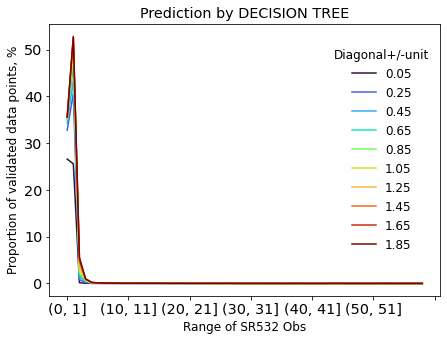

In [234]:
# quantifier le gain des points en fonction de gamme de SR
#---------------------------------------------------------
plt.clf()
j=0
FIG, ax = plt.subplots(figsize=(7,5))
# plt.rcParams.update({'font.size':12})
for DF in DF_PTS:
    DF = pd.DataFrame(DF, columns=['QUANTIFIED_POINTS'])
    DF_PTS_GROUPED = DF.groupby(pd.cut(DF['QUANTIFIED_POINTS'], np.arange(0,60,1))).sum()/SR532.shape[0]
    (100*DF_PTS_GROUPED).plot(y='QUANTIFIED_POINTS', ax=ax, label=f'{np.round(UNIT_VALUE[j], 2)}', logy=False)
    j=j+1
    
colormap = plt.cm.turbo 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.legend(frameon=False, title='Diagonal+/-unit', bbox_to_anchor=(1, 0.95))
plt.xlabel('Range of SR532 Obs')
plt.ylabel('Proportion of validated data points, %')
plt.title('Prediction by F(X)')

j=0
FIG, ax = plt.subplots(figsize=(7,5))

for DF in DF_PTS_TREE:
    DF = pd.DataFrame(DF, columns=['QUANTIFIED_POINTS'])
    DF_PTS_GROUPED = DF.groupby(pd.cut(DF['QUANTIFIED_POINTS'], np.arange(0,60,1))).sum()/SR532_TREE.shape[0]
    (100*DF_PTS_GROUPED).plot(y='QUANTIFIED_POINTS', ax=ax, label=f'{np.round(UNIT_VALUE[j], 2)}', logy=False)
    j=j+1
    
colormap = plt.cm.turbo 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.legend(frameon=False, title='Diagonal+/-unit', bbox_to_anchor=(1, 0.95))
plt.xlabel('Range of SR532 Obs')
plt.ylabel('Proportion of validated data points, %')
plt.title('Prediction by DECISION TREE')

In [210]:
def predband(x, yp, xd, yd, ydp, p, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # yp = requested predictive points
    # ydp = y data predictive
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - ydp) ** 2))
    
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    
    # Predicted values (best-fit model)
    yp = func(x, *p)
    
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb


In [211]:
SR355 = pd.read_pickle(Path(MAINDIR, 'SR355_ravel.pkl')).values.ravel()
SR355_TREE = pd.read_pickle(Path(MAINDIR, 'SR355_TREE_ravel.pkl')).values.ravel()

lowerband, upperband = predband(x = np.arange(0,60,1),
                                y = f()
                               xd = SR355,
                               yd = SR532,
                               )




TypeError: predband() missing 3 required positional arguments: 'yp', 'ydp', and 'p'

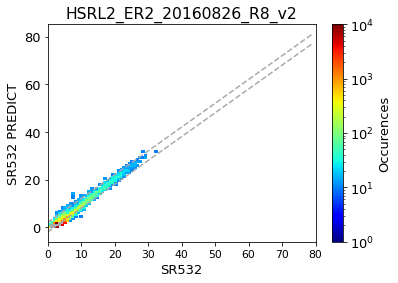

In [69]:
H, XBINS, YBINS = np.histogram2d(SR532.values.ravel(), SR532_PRED.ravel(), bins=100, range=[[0,80], [0,80]])
H_FILTED = np.where(H < 10, np.nan, H)


FIG, (AX, AX2, AX3) = plt.subplots(ncols =3, figsize=(14,5))

P = AX.pcolormesh(XBINS, YBINS, H_FILTED, norm=LogNorm(vmin=1e0, vmax=1e4), cmap=cmapp)
plt.colorbar(P, ax=AX, label='Occurences')
plt.xlabel('SR532')
plt.ylabel('SR532 PREDICT')
plt.title(f'{FILE.stem}')

AX.plot(np.arange(0,80,1), np.arange(0+2,80+2,1), linestyle='--', c='darkgrey')
AX.plot(np.arange(0,80,1), np.arange(0-2,80-2,1), linestyle='--', c='darkgrey')

In [77]:
DF = pd.DataFrame(np.concatenate((SR532.values.ravel().reshape(-1,1), SR355.values.ravel().reshape(-1,1)), axis=1), columns=['SR532', 'SR355'])

In [86]:
DF['SR355_RANGES'] = pd.cut(DF['SR355'], pd.interval_range(start=0, end=80, periods=100))
DF['SR532_RANGES'] = pd.cut(DF['SR532'], pd.interval_range(start=0, end=80, periods=100))

In [111]:
SR355_FILTED_INDEX = DF['SR355'].map(DF[['SR355_RANGES', 'SR532_RANGES']].value_counts(dropna=True) > 10)
SR532_FILTED_INDEX = DF['SR532'].map(DF[['SR355_RANGES', 'SR532_RANGES']].value_counts(dropna=True) > 10)

In [125]:
(DF[['SR355_RANGES', 'SR532_RANGES']].value_counts(dropna=True) > 10).index

MultiIndex([(                (0.8, 1.6], ...),
            (                (0.0, 0.8], ...),
            (                (0.8, 1.6], ...),
            (                (0.0, 0.8], ...),
            (                (0.8, 1.6], ...),
            (                (0.0, 0.8], ...),
            (                (0.8, 1.6], ...),
            (                (0.8, 1.6], ...),
            ( (1.6, 2.4000000000000004], ...),
            ( (1.6, 2.4000000000000004], ...),
            ...
            (                (7.2, 8.0], ...),
            (                (7.2, 8.0], ...),
            (                (7.2, 8.0], ...),
            ((12.8, 13.600000000000001], ...),
            (                (7.2, 8.0], ...),
            (                (7.2, 8.0], ...),
            ((12.8, 13.600000000000001], ...),
            (                (7.2, 8.0], ...),
            (                (7.2, 8.0], ...),
            (              (20.8, 21.6], ...)],
           names=['SR355_RANGES', 'SR532_RA

In [112]:
SR532_FILTED = SR532.values.ravel()[SR532_FILTED_INDEX.astype(bool)]
SR532_PRED_FILTED = SR532_PRED.ravel()[SR532_FILTED_INDEX.astype(bool)]
SR355_FILTED = SR355.values.ravel()[SR355_FILTED_INDEX.astype(bool)]

In [113]:
SR355_FILTED[~np.isnan(SR355_FILTED)]

array([5.53759816, 1.09328179, 1.07180039, ..., 0.87565918, 0.8634785 ,
       0.85026062])

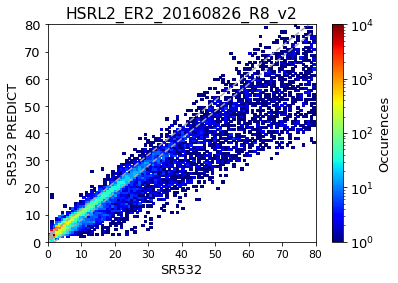

In [115]:
FIG, AX = plt.subplots()

H = AX.hist2d(SR532_FILTED, SR532_PRED_FILTED, range=[[0,80], [0,80]], bins= 100, 
              norm=LogNorm(vmin=1e0, vmax=1e4), cmap=cmapp)
plt.colorbar(P, ax=AX, label='Occurences')
plt.xlabel('SR532')
plt.ylabel('SR532 PREDICT')
plt.title(f'{FILE.stem}')

AX.plot(np.arange(0,80,1), np.arange(0+2,80+2,1), linestyle='--', c='darkgrey')
AX.plot(np.arange(0,80,1), np.arange(0-2,80-2,1), linestyle='--', c='darkgrey')